In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda")
torch.cuda.set_device(0)

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


DECODER: generates images for synthetic data

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, image_shape):
        super().__init__()
        C, H, W = image_shape
        self.image_shape = image_shape
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, C * H * W),
            nn.Tanh()
        )

    def forward(self, z):
        return self.fc(z).view(-1, *self.image_shape)

U generation

In [48]:
class Gen_U(nn.Module):
    def __init__(self, dz2, d_U):
        super().__init__()
        self.map = nn.Sequential(
                      nn.Linear(dz2, 64),
                      nn.ReLU(),
                      nn.Linear(64, d_U)
       )

    def forward(self, z):
        return F.relu(self.map(z))

OUTCOME FUNCTION

In [49]:
class OutFunc(nn.Module):
    def __init__(self, d_X, d_U):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_X + d_U, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, u):
        x_flatten = x.view(x.size(0), -1)
        return self.net(torch.cat([x_flatten, u], dim=1)).squeeze(-1)

Synthetic data generation

In [50]:
def generate_synthetic(num_obs=5000,image_shape=(1, 32, 32),dz1=10, dz2=10,
    sig_x=0.5 , sig_u=0.5 ,beta_mag=3.0):

    C, H, W = image_shape
    d_X = C * H * W
    d_U = dz2

    G_X = Decoder(dz1, image_shape).to(device).eval()
    G_U = Gen_U(dz2, d_U).to(device).eval()
    f_0 = OutFunc(d_X, d_U).to(device).eval()
    f_1 = OutFunc(d_X, d_U).to(device).eval()

    with torch.no_grad():
        Z_1 = torch.randn(num_obs, dz1, device=device)
        Z_2 = torch.randn(num_obs, dz2, device=device)

        # Generate X and add noise
        X = G_X(Z_1)
        X = X + sig_x * torch.randn_like(X)

        # Generate U and add noise
        U = G_U(Z_2)
        U = U + sig_u * torch.randn_like(U)

        # Treatment assignment
        alpha = 0.1 * torch.randn(d_X, device=device)
        v = torch.randn(d_U, device=device)
        beta = v / v.norm() * beta_mag

        probs = torch.sigmoid(X.view(num_obs, -1) @ alpha + U @ beta)
        T = torch.bernoulli(probs)

        Y_0 = f_0(X, U) + 0.01 * torch.randn(num_obs, device=device)
        Y_1 = f_1(X, U) + 0.01 * torch.randn(num_obs, device=device)
        Y = torch.where(T == 1, Y_1, Y_0)

    return X, T, Y, Y_0, Y_1, U


TARNET ARCHITECTURE CODE

In [51]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, in_channels, rep_dim=256):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(128, rep_dim)

    def forward(self, x):
        h = self.features(x).view(x.size(0), -1)
        return self.fc(h)


class TARNet(nn.Module):
    def __init__(self, rep_dim=256, hidden_dim=200):
        super().__init__()
        self.encoder = CNNFeatureExtractor(1, rep_dim)
        self.head0 = nn.Sequential(nn.Linear(rep_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))
        self.head1 = nn.Sequential(nn.Linear(rep_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))

    def forward(self, x, t=None):
        rep = self.encoder(x)
        y0 = self.head0(rep).squeeze(-1)
        y1 = self.head1(rep).squeeze(-1)
        if t is None:
            return y0, y1, rep
        return torch.where(t == 1, y1, y0)

TRAINING

In [52]:
def train_tarnet(beta_mag, epochs=30, batch=128, lr=1e-3):
    X, T, Y, _, _, _ = generate_synthetic(num_obs=9000, beta_mag=beta_mag)

    idx = torch.randperm(len(X), device=device)
    train_idx = idx[:5000]
    val_idx   = idx[5000:]

    train_data = torch.utils.data.TensorDataset(X[train_idx], T[train_idx], Y[train_idx])
    loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=0)

    model = TARNet().to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    model.train()
    for _ in range(epochs):
        for x, t, y in loader:
            opt.zero_grad()
            pred = model(x, t)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

    return model

EVALUATION

In [53]:
def evaluate(model, beta_mag, n=1000):
    X, T, Y, Y0, Y1, _ = generate_synthetic(num_obs=n, beta_mag=beta_mag)
    model.eval()

    with torch.no_grad():
        y0_pred, y1_pred, _ = model(X, t=None)
        pred_fact = model(X, T)

        mse = F.mse_loss(pred_fact, Y).item()
        ite_pred = y1_pred - y0_pred
        ite_true = Y1 - Y0
        pehe = torch.sqrt(F.mse_loss(ite_pred, ite_true)).item()

    return mse, pehe

In [54]:
def run_experiment(beta_values, epochs=30, runs=5):
    results = {
        "beta": [],
        "pehe_best": [],
        "pehe_mean": [],
        "pehe_std": [],
        "mse_best": [],
        "mse_mean": [],
        "mse_std": []
    }

    for beta in beta_values:
        pehe_list = []
        mse_list = []

        print(f"Running β={beta} ...")

        for r in range(runs):
            torch.cuda.empty_cache()

            # Train TARNet
            model = train_tarnet(beta, epochs=epochs)

            # Evaluate
            mse, pehe = evaluate(model, beta)

            pehe_list.append(pehe)
            mse_list.append(mse)

            del model
            torch.cuda.empty_cache()

        # Store
        results["beta"].append(beta)

        # PEHE stats
        results["pehe_best"].append(min(pehe_list))
        results["pehe_mean"].append(np.mean(pehe_list))
        results["pehe_std"].append(np.std(pehe_list))

        # MSE stats
        results["mse_best"].append(min(mse_list))
        results["mse_mean"].append(np.mean(mse_list))
        results["mse_std"].append(np.std(mse_list))

    return results


Plot results for beta

In [55]:
def plot_results_multi_run(results):
    beta = np.array(results["beta"])

    pehe_best = np.array(results["pehe_best"])
    pehe_mean = np.array(results["pehe_mean"])
    pehe_std  = np.array(results["pehe_std"])

    mse_best = np.array(results["mse_best"])
    mse_mean = np.array(results["mse_mean"])
    mse_std  = np.array(results["mse_std"])

    plt.figure(figsize=(12, 5))

    # PEHE
    plt.subplot(1, 2, 1)
    plt.plot(beta, pehe_mean, "o-", label="PEHE mean", color="darkred")
    plt.fill_between(beta, pehe_mean - pehe_std, pehe_mean + pehe_std,
                     color="darkred", alpha=0.2, label="PEHE ± std")
    plt.plot(beta, pehe_best, "s--", color="black", label="PEHE best run")

    plt.xlabel("Magnitude of β")
    plt.ylabel("PEHE")
    plt.title("PEHE vs β")
    plt.grid(True)
    plt.legend()

    # MSE
    plt.subplot(1, 2, 2)
    plt.plot(beta, mse_mean, "o-", label="MSE mean", color="navy")
    plt.fill_between(beta, mse_mean - mse_std, mse_mean + mse_std,
                     color="navy", alpha=0.2, label="MSE ± std")
    plt.plot(beta, mse_best, "s--", color="black", label="MSE best run")

    plt.xlabel("Magnitude of β")
    plt.ylabel("MSE")
    plt.title("MSE vs β")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()



Running β=0 ...
Running β=1 ...
Running β=2 ...
Running β=3 ...
Running β=4 ...
Running β=5 ...


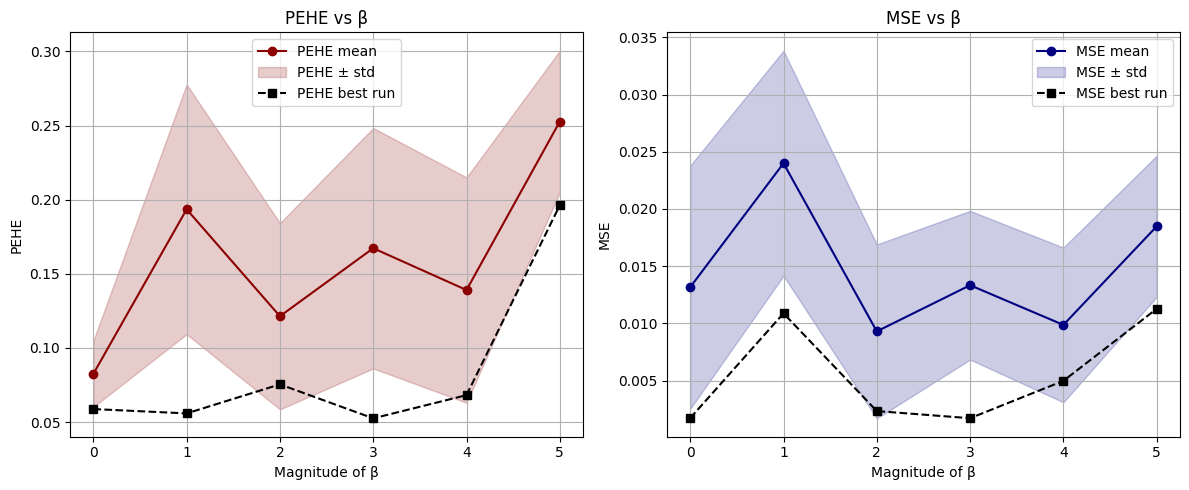

In [57]:
betas = [0, 1, 2, 3, 4, 5]
results = run_experiment(beta_values=betas, epochs=50)
plot_results_multi_run(results)


Train for varying hidden dimensions

In [58]:
def run_experiment_dz2(dz2_values, beta_mag=5, epochs=30, runs=3):
    results = {
        "dz2": [],
        "pehe_mean": [],
        "pehe_std": [],
        "mse_mean": [],
        "mse_std": []
    }

    for dz2 in dz2_values:
        pehe_list = []
        mse_list = []

        print(f"Running d_z2={dz2}")

        for r in range(runs):
            # Generate synthetic data with this dz2
            X, T, Y, _, _, _ = generate_synthetic(
                num_obs=9000,
                dz2=dz2,
                beta_mag=beta_mag
            )

            # Prepare dataloader
            dataset = torch.utils.data.TensorDataset(X, T, Y)
            loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

            # Create TARNet
            model = TARNet().to(device)
            opt = optim.Adam(model.parameters(), lr=1e-3)
            loss_fn = nn.MSELoss()

            # Train
            for _ in range(epochs):
                for x, t, y in loader:
                    opt.zero_grad()
                    pred = model(x, t)
                    loss = loss_fn(pred, y)
                    loss.backward()
                    opt.step()

            # Evaluate on 1000 new samples
            mse, pehe = evaluate(model, beta_mag)
            pehe_list.append(pehe)
            mse_list.append(mse)

            del model
            torch.cuda.empty_cache()

        # Store results
        results["dz2"].append(dz2)
        results["pehe_mean"].append(np.mean(pehe_list))
        results["pehe_std"].append(np.std(pehe_list))
        results["mse_mean"].append(np.mean(mse_list))
        results["mse_std"].append(np.std(mse_list))

    return results


In [59]:
def plot_dz2_results(results):
    dz2 = np.array(results["dz2"])

    pehe_mean = np.array(results["pehe_mean"])
    pehe_std  = np.array(results["pehe_std"])

    mse_mean  = np.array(results["mse_mean"])
    mse_std   = np.array(results["mse_std"])

    plt.figure(figsize=(12, 5))

    # PEHE
    plt.subplot(1, 2, 1)
    plt.plot(dz2, pehe_mean, "o-", label="PEHE mean", color="darkred")
    plt.fill_between(dz2, pehe_mean - pehe_std, pehe_mean + pehe_std,
                     color="darkred", alpha=0.2, label="PEHE ± std")

    plt.xlabel("d_z2 (latent confounder dimension)")
    plt.ylabel("PEHE")
    plt.title("Effect of latent confounder dimension on PEHE")
    plt.grid(True)
    plt.legend()

    # MSE
    plt.subplot(1, 2, 2)
    plt.plot(dz2, mse_mean, "o-", label="MSE mean", color="navy")
    plt.fill_between(dz2, mse_mean - mse_std, mse_mean + mse_std,
                     color="navy", alpha=0.2, label="MSE ± std")

    plt.xlabel("d_z2 (latent confounder dimension)")
    plt.ylabel("MSE")
    plt.title("Effect of latent confounder dimension on MSE")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


Running d_z2=2
Running d_z2=4
Running d_z2=6
Running d_z2=8
Running d_z2=10
Running d_z2=20
Running d_z2=30


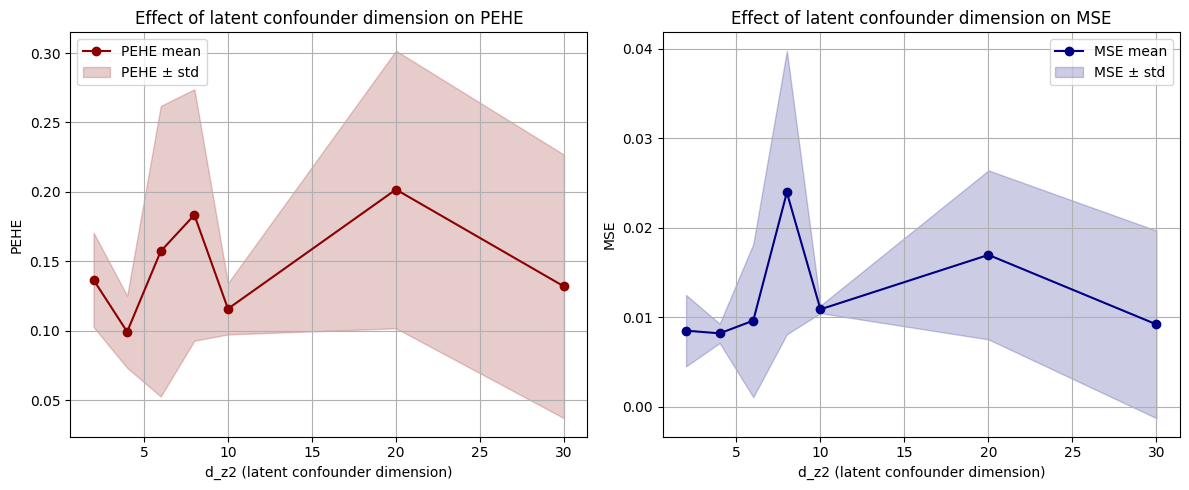

In [60]:
dz2_vals = [2, 4, 6, 8, 10, 20, 30]

results_dz2 = run_experiment_dz2(
    dz2_values=dz2_vals,
    beta_mag=5,
    epochs=40,
    runs=3
)

plot_dz2_results(results_dz2)
